In [1]:
from __future__ import division
import pyopencl as cl
import numpy as np
import pylab
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
%matplotlib inline

In [42]:
def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r


In [74]:
platforms = cl.get_platforms()
print 'The platforms detected are:'
print '---------------------------'
for platform in platforms:
    print platform.name, platform.vendor, 'version:', platform.version

# List devices in each platform
for platform in platforms:
    print 'The devices detected on platform', platform.name, 'are:'
    print '---------------------------'
    for device in platform.get_devices():
        print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
        print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
        print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
        print 'Maximum work group size', device.max_work_group_size
        print '---------------------------'

# Create a context with all the devices
devices = platforms[0].get_devices()
context = cl.Context(devices)
print 'This context is associated with ', len(context.devices), 'devices'

queue = cl.CommandQueue(context, context.devices[0],
                        properties=cl.command_queue_properties.PROFILING_ENABLE)
print 'The queue is using the device:', queue.device.name

program = cl.Program(context, open('HDR_mask.cl').read()).build(options='')


im0 = scipy.misc.imread('test_large.jpg', flatten=True)
him0 = im0.copy()
him0 = np.array(him0, dtype=np.float32)
him0.shape
mask = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).astype(np.float32)

print mask
out = np.zeros_like(him0).astype(np.float32)
gpu_0 = cl.Buffer(context, cl.mem_flags.READ_ONLY, him0.size * 4)
gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, out.size * 4)
# gpu of mask
gpu_mask = cl.Buffer(context, cl.mem_flags.READ_ONLY, mask.size * 4)

cl.enqueue_copy(queue, gpu_0, him0, is_blocking=False)
cl.enqueue_copy(queue, gpu_mask, mask, is_blocking=False)
#cl.enqueue_copy(queue, gpu_sat, saturation, is_blocking=False)


local_size = (8, 8)
global_size = tuple([round_up(g, l) for g, l in zip(him0.shape[::-1], local_size)])

width = np.int32(him0.shape[1])
height = np.int32(him0.shape[0])
halo = np.int32(1)


event = program.mask_nobuffer(queue, global_size, local_size,
                           gpu_0, gpu_mask, gpu_out,
                           width, height, np.int32(mask.shape[1]), np.int32(mask.shape[0]))

cl.enqueue_copy(queue, out, gpu_out, is_blocking=True)

seconds = (event.profile.end - event.profile.start) / 1e9


The platforms detected are:
---------------------------
Apple Apple version: OpenCL 1.2 (Sep 20 2014 22:01:02)
The devices detected on platform Apple are:
---------------------------
Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz [Type: CPU ]
Maximum clock Frequency: 2400 MHz
Maximum allocable memory size: 2147 MB
Maximum work group size 1024
---------------------------
Iris [Type: GPU ]
Maximum clock Frequency: 1100 MHz
Maximum allocable memory size: 402 MB
Maximum work group size 512
---------------------------
This context is associated with  2 devices
The queue is using the device: Iris
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]


In [75]:
gshow = lambda img: plt.imshow(img.astype(int), cmap = plt.get_cmap('gray'))

In [76]:
him0.shape

(3648, 5472)

In [80]:
him0

array([[  89.        ,   86.        ,   84.        , ...,  113.80599976,
         113.81700134,  112.81700134],
       [  88.        ,   85.        ,   83.        , ...,  113.80599976,
         113.81700134,  113.81700134],
       [  86.        ,   84.        ,   82.        , ...,  114.80599976,
         114.81700134,  114.81700134],
       ..., 
       [ 117.69499969,  133.16799927,  134.8690033 , ...,  109.72899628,
         108.72899628,  108.72899628],
       [ 110.69499969,  127.16799927,  135.16799927, ...,  112.72899628,
         110.72899628,  110.72899628],
       [ 113.69499969,  125.69499969,  131.16799927, ...,  116.72899628,
         114.72899628,  114.72899628]], dtype=float32)

In [78]:
out

array([[  89.        ,   86.        ,   84.        , ...,  113.80599976,
         113.81700134,  112.81700134],
       [  88.        ,   85.        ,   83.        , ...,  113.80599976,
         113.81700134,  113.81700134],
       [  86.        ,   84.        ,   82.        , ...,  114.80599976,
         114.81700134,  114.81700134],
       ..., 
       [ 117.69499969,  133.16799927,  134.8690033 , ...,  109.72899628,
         108.72899628,  108.72899628],
       [ 110.69499969,  127.16799927,  135.16799927, ...,  112.72899628,
         110.72899628,  110.72899628],
       [ 113.69499969,  125.69499969,  131.16799927, ...,  116.72899628,
         114.72899628,  114.72899628]], dtype=float32)

In [81]:
out==him0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [84]:
import copy

In [88]:
from PIL import Image

In [90]:
new = Image.fromarray(out)

In [91]:
new.show()

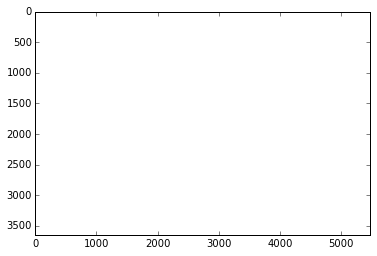

In [92]:
gshow(out)

In [62]:
temp = out.copy()

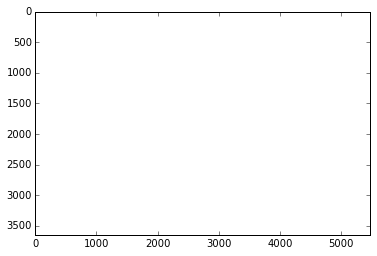

In [64]:
gshow(temp.astype(int))

In [ ]:
# This is the mask adding version with halo
def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r


if __name__ == '__main__':
    # List our platforms
    platforms = cl.get_platforms()
    print 'The platforms detected are:'
    print '---------------------------'
    for platform in platforms:
        print platform.name, platform.vendor, 'version:', platform.version

    # List devices in each platform
    for platform in platforms:
        print 'The devices detected on platform', platform.name, 'are:'
        print '---------------------------'
        for device in platform.get_devices():
            print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
            print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
            print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
            print 'Maximum work group size', device.max_work_group_size
            print '---------------------------'

    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)
    print 'This context is associated with ', len(context.devices), 'devices'

    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open('HDR_mask.cl').read()).build(options='')


    im0 = #np.array(Image.open("test_large.jpg").getdata())
    him0 = im0.astype(np.float32).copy()

    #print 'him0 shape: ', him0
    # get size of him0
    #im_x, im_y = him0.shape

    # create an identity mask array
    #mask = np.zeros(shape=(612*612, 3))
    #for i in range(612):
    #    mask[612*i+i,:]=0.5

    # mask that takes 1/2 for each pixal
    #mask = 0.5*np.ones(shape=(499392, 3)).astype(np.float32)

    #lumR = 0.2125
    # lumG = 0.7154
    # lumB = 0.0721
    # # saturation parameter
    # s = 1.4
    # sr = (1 - s) * lumR
    # sg = (1 - s) * lumG
    # sb = (1 - s) * lumB
    # create mask matrix
    #mask = [[sr+s, sr, sr], [sg, sg+s, sg], [sb, sb, sb+s]].astype(np.float32)
    # sharpen
    #mask = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]).astype(np.float32)
    mask = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).astype(np.float32)

    print mask
    #print 'mask shape: ', mask.shape

    #saturation = s*np.ones_like(him0).astype(np.float32)

    out = np.zeros_like(him0).astype(np.float32)

    gpu_0 = cl.Buffer(context, cl.mem_flags.READ_ONLY, him0.size * 4)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, out.size * 4)
    # gpu of mask
    gpu_mask = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, mask.size * 4)

    cl.enqueue_copy(queue, gpu_0, him0, is_blocking=False)
    cl.enqueue_copy(queue, gpu_mask, mask, is_blocking=False)
    #cl.enqueue_copy(queue, gpu_sat, saturation, is_blocking=False)


    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(him0.shape[::-1], local_size)])

    width = np.int32(him0.shape[1]) # 3
    height = np.int32(him0.shape[0]) # 499392
    halo = np.int32(1)

    # Set up a (N+2 x N+2) local memory buffer.
    # +2 for 1-pixel halo on all sides, 4 bytes for float.
    buf_size = (np.int32(local_size[0] + 2 * halo), np.int32(local_size[1] + 2 * halo))
    buf_w = np.int32(local_size[0] + 2)
    buf_h = np.int32(local_size[1] + 2)
    local_memory = cl.LocalMemory(4 * buf_size[0] * buf_size[1])
    # Each work group will have its own private buffer.


    event = program.mask(queue, global_size, local_size,
                               gpu_0, gpu_mask, gpu_out, local_memory,
                               buf_size[0], buf_size[1], width, height, halo)

    cl.enqueue_copy(queue, a, gpu_out, is_blocking=True)

    seconds = (event.profile.end - event.profile.start) / 1e9
    print("{} Million Complex FMAs in {} seconds, {} million Complex FMAs / second".format(out.sum() / 1e6, seconds, (out.sum() / seconds) / 1e6))



    #print out
    #out = np.reshape(out, (612,816,3)).astype(np.uint8)
    #out_f = Image.fromarray(out, 'RGB')
    #out_f.show()

    print out
    pylab.imshow(out)
    pylab.show()

The platforms detected are:
---------------------------
Apple Apple version: OpenCL 1.2 (Sep 20 2014 22:01:02)
The devices detected on platform Apple are:
---------------------------
Intel(R) Core(TM) i5-4258U CPU @ 2.40GHz [Type: CPU ]
Maximum clock Frequency: 2400 MHz
Maximum allocable memory size: 2147 MB
Maximum work group size 1024
---------------------------
Iris [Type: GPU ]
Maximum clock Frequency: 1100 MHz
Maximum allocable memory size: 402 MB
Maximum work group size 512
---------------------------
This context is associated with  2 devices
The queue is using the device: Iris
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
0.0 Million Complex FMAs in -34.71907272 seconds, -0.0 million Complex FMAs / second